In [1]:
import pandas as pd
import numpy as np

In [12]:
df=pd.read_csv(r"/content/clustered_df.csv")

In [13]:
df = df.sample(n=min(5000, len(df)), random_state=42).reset_index(drop=True)


In [14]:
df.head()

,Unnamed: 0,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,...,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,Cluster
0,1501,0.6880,1980,0.0311,['Nazareth'],0.615,216253,0.834,0,4HoTskE5N0oEM4CKRfuzFI,...,7,0.1430,-5.726,1,Holiday,29,1980,0.0318,131.606,1
1,2586,0.0391,1942,0.9890,"['Giacomo Puccini', 'Leontyne Price', 'Erich L...",0.290,299120,0.167,0,2VtUcZ1yowXnhotD3yPAaW,...,1,0.2900,-15.035,1,"Un bel dì (From ""Madama Butterfly"")",0,1942,0.0450,104.500,2
2,2653,0.9620,1950,0.6350,['La Sonora Santanera'],0.679,181933,0.486,0,0rd7q2ibicTeKNbLUl3gTV,...,7,0.3610,-10.397,0,Pena Negra,27,1950,0.0337,131.198,0
3,1055,0.5900,1971,0.2420,['Jimi Hendrix'],0.460,249920,0.720,0,11t59LqOhOEG40yqALXZon,...,1,0.5280,-11.263,1,Ezy Ryder,38,1971,0.0525,123.548,4
4,705,0.8520,2005,0.1390,['Alabama'],0.747,214880,0.460,0,6WJKrF37Bz6CKr3fOtxJHS,...,7,0.0801,-12.797,1,The Closer You Get,40,2005-05-17,0.0280,114.254,1


**Feature and Scaling **

In [16]:
# Select relevant numerical features for clustering
from sklearn.preprocessing import StandardScaler

numerical_features = [
    "valence", "danceability", "energy", "tempo",
    "acousticness", "liveness", "speechiness", "instrumentalness"
]

# Standardize the numerical features
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df[numerical_features]), columns=numerical_features)

In [17]:
df_scaled

,valence,danceability,energy,tempo,acousticness,liveness,speechiness,instrumentalness
0,0.626503,0.446602,1.290997,0.467091,-1.240308,-0.362372,-0.413981,-0.536868
1,-1.848304,-1.400498,-1.157184,-0.416965,1.281545,0.462644,-0.337475,-0.536790
2,1.671498,0.810339,0.013685,0.453784,0.349573,0.861121,-0.402969,-0.536877
3,0.252746,-0.434322,0.872567,0.204281,-0.685073,1.798384,-0.294005,-0.510473
4,1.251975,1.196809,-0.081747,-0.098841,-0.956240,-0.715388,-0.436006,-0.536874
...,...,...,...,...,...,...,...,...
4995,-1.074474,0.344301,-0.815834,0.582743,1.163074,0.002431,-0.316609,2.052701
4996,-1.387210,-1.377764,1.379087,0.093880,-1.318235,0.703975,-0.197792,-0.343056
4997,0.729477,0.116966,0.314661,0.634405,-0.721931,-0.618856,-0.306177,-0.535031
4998,0.904914,1.043358,-1.285650,0.343416,-0.821973,-0.362372,4.762966,-0.536877


Train Test Data

In [18]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(df_scaled,random_state=42,test_size=0.2)

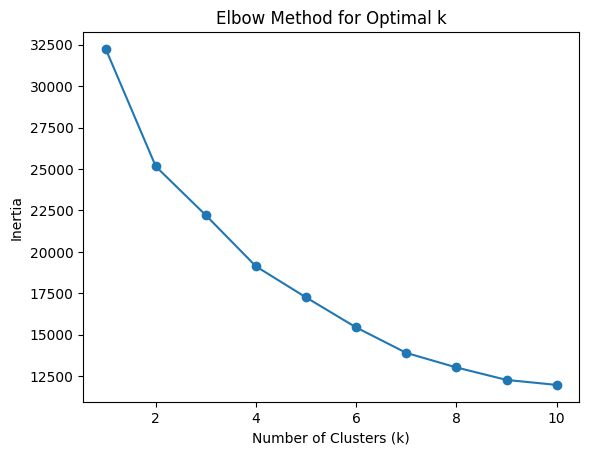

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

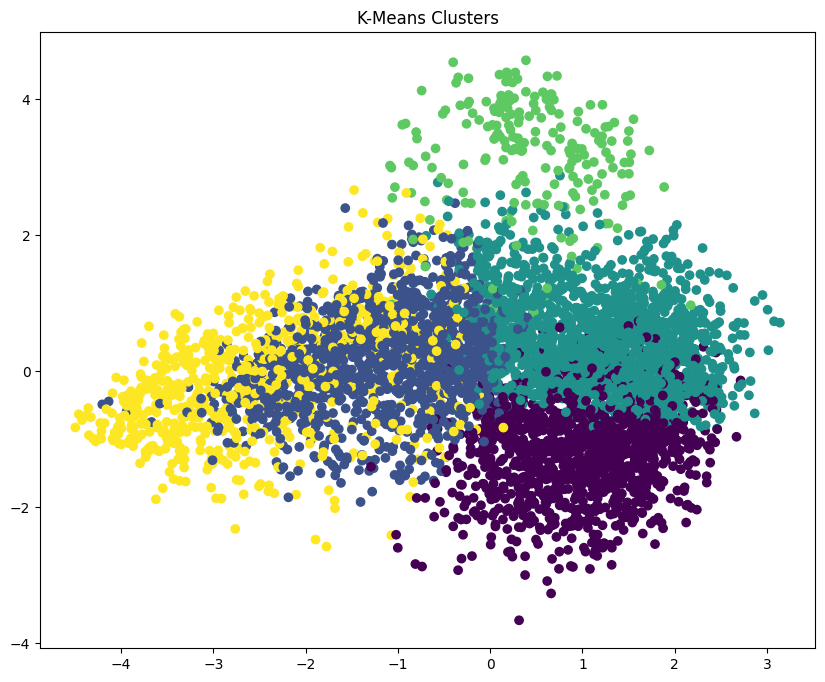

In [20]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(10,8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["Cluster"], cmap="viridis")
plt.title("K-Means Clusters")
plt.show()

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Get the cluster of the input song
    song_cluster = df[df["name"] == song_name]["Cluster"].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df["Cluster"] == song_cluster]

    # Calculate similarity within the cluster
    song_index = same_cluster_songs[same_cluster_songs["name"] == song_name].reset_index(drop=True).index[0]
    cluster_features = same_cluster_songs[numerical_features]
    similarity = cosine_similarity(cluster_features, cluster_features)

    # Get top recommendations
    similar_songs = np.argsort(similarity[song_index])[-(num_recommendations + 1):-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]

    return recommendations


In [25]:
# Example usage
input_song = "Soul Junction"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Soul Junction':


,name,year,artists
988,Almost Cried,1959,['Duke Ellington']
279,"Debussy: Préludes, Livre II, CD 131, L. 123: N...",1953,"['Claude Debussy', 'Walter Gieseking']"
1814,"Sonate pour piano No. 3 in B Minor, Op. 58: II...",1926,"['Frédéric Chopin', 'Wilhelm Kempff']"
416,Wehrmut,1977,"['Cluster', 'Eno']"
1252,"Mazurkas, Op. 59: No. 1 in A Minor",1946,"['Frédéric Chopin', 'Arthur Rubinstein']"
